In [153]:
import pandas as pd
from pyAudioProcessing.extract_features import get_features




# Load paths and labels

In [3]:
import os
import pathlib
import time

import numpy as np
import pydub

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sb
sb.set(style="white", palette="muted")

def load_data(machine, Data = 'normal', base_dir = 'data/', id = [0, 2, 4, 6]):
    '''
     Find the audio directory
     Inputs:
     machine: Name of the machine (valve/slider/fan/pump)
     id: ID of the machine (0,2,4,6)
     base_dir = Base directory of the dataset

     Outputs:
     dir = List of data adresses
     label = List of labels (0 -> normal, 1 -> abnormal)
     '''


    dir = []
    label = []

    for id in id:
        normaldir = base_dir + machine + '/id_' + str(format(id,'02d')) + '/normal'
        abnormaldir = base_dir + machine + '/id_' + str(format(id,'02d')) + '/abnormal'
        if Data == 'normal':
            list = os.listdir(normaldir)
            for i in list:
                dir_address = normaldir + '/' + i
                dir.append(dir_address)
                label.append(0)

        else:
            list = os.listdir(abnormaldir)
            for i in list:
                dir_address = abnormaldir + '/' + i
                dir.append(dir_address)
                label.append(1)

    return dir,label


C:\Users\AHUSSEI9\Anaconda3\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [4]:
import pandas as pd
device='fan'
dir,label = load_data(device)

dir_abnormal,label_abnormal = load_data(device, Data='abnormal')


f1 = {'filename': (dir_abnormal + dir), 'label': (label_abnormal + label)}
df = pd.DataFrame(f1)
df

,filename,label
0,data/fan/id_00/abnormal/00000000.wav,1
1,data/fan/id_00/abnormal/00000001.wav,1
2,data/fan/id_00/abnormal/00000002.wav,1
3,data/fan/id_00/abnormal/00000003.wav,1
4,data/fan/id_00/abnormal/00000004.wav,1
...,...,...
5545,data/fan/id_06/normal/00001010.wav,0
5546,data/fan/id_06/normal/00001011.wav,0
5547,data/fan/id_06/normal/00001012.wav,0
5548,data/fan/id_06/normal/00001013.wav,0


# Define feature extraction functions

In [5]:
import torch 
import torchaudio
import torchaudio.transforms as transforms
from IPython.display import Audio
import librosa

torch.random.manual_seed(0)

# def mfcc_extract(filename):
#
#     y, sr  = librosa.load(filename, sr = 16000)
#     mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, n_fft=2048, hop_length=512)
#     return mfcc

C:\Users\AHUSSEI9\Anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


# Mfcc and Lfcc using Torch audio

In [6]:

n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128
n_mfcc = 13
input_freq=16000

def mfcc_extract(filename):

    y, _ = torchaudio.load(filename, normalize=True)
    transform = transforms.MFCC(sample_rate = input_freq, n_mfcc=n_mfcc,
        melkwargs={
            "n_fft": n_fft,
            "n_mels": n_mels,
            "win_length": win_length,
            "hop_length": hop_length,
        },)
    mfcc = transform(y).numpy()

    return mfcc


n_lfcc = 13

def lfcc_extract(filename):
    y, _ = torchaudio.load(filename, normalize=True)
    transform = transforms.LFCC(
        sample_rate=input_freq,
        n_lfcc=n_lfcc,
        speckwargs={
            "n_fft": n_fft,
            "win_length": win_length,
            "hop_length": hop_length,
        },
    )
    lfcc = transform(y)
    return lfcc.numpy()

## plotting function
def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)



### Test on sample path

In [7]:
mfcc_test = mfcc_extract(df.filename[1])
mfcc_test_normal = mfcc_extract(df.filename[1476])

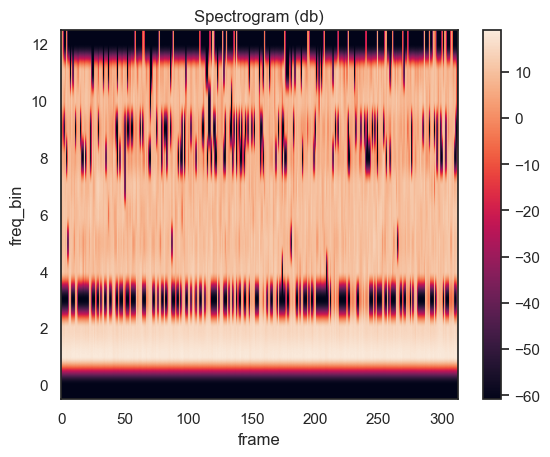

In [8]:
plot_spectrogram(mfcc_test[7])

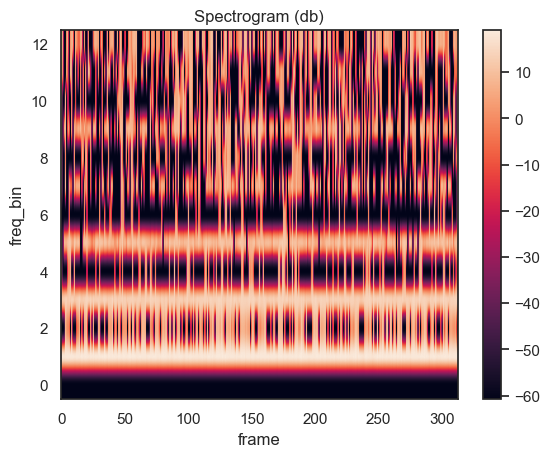

In [9]:
plot_spectrogram(mfcc_test_normal[7])

### Apply to full list of paths for clustering

In [10]:
from ipywidgets import IntProgress
from IPython.display import display
import time

In [11]:
mfcc = df['filename'].apply(lambda x: mfcc_extract(x))
lfcc = df['filename'].apply(lambda x: lfcc_extract(x))

In [12]:
len(mfcc[1])

8

In [13]:
len(mfcc[1][1])

13

## Pitch

In [14]:
import torchaudio.functional as F
import torch

def wave_sr_extract(filename):
    y, sr = torchaudio.load(filename, normalize=True)
    return y, sr

def pitch_extract(w,sr):
    pitch = F.detect_pitch_frequency(w, sr)
    return pitch

def df_pitch_extract(filename):
    w, sr = torchaudio.load(filename, normalize=True)
    pitch = F.detect_pitch_frequency(w, sr)
    return pitch


def plot_pitch(waveform, sr, pitch):
    figure, axis = plt.subplots(1, 1)
    axis.set_title("Pitch Feature")
    axis.grid(True)

    end_time = waveform.shape[1] / sr
    time_axis = torch.linspace(0, end_time, waveform.shape[1])
    axis.plot(time_axis, waveform[0], linewidth=1, color="gray", alpha=0.3)

    axis2 = axis.twinx()
    time_axis = torch.linspace(0, end_time, pitch.shape[1])
    axis2.plot(time_axis, pitch[0], linewidth=2, label="Pitch", color="green")

    axis2.legend(loc=0)
    plt.show(block=False)


In [15]:
w1, sr1 = wave_sr_extract(df.filename[2])
w2, sr2 = wave_sr_extract(df.filename[1481])
pitch1 = pitch_extract(w1,sr1)
pitch2 = pitch_extract(w2,sr2)

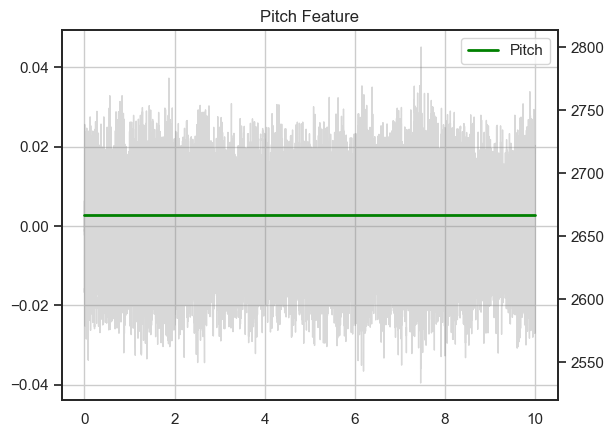

In [16]:
plot_pitch(w1, sr1, pitch1)

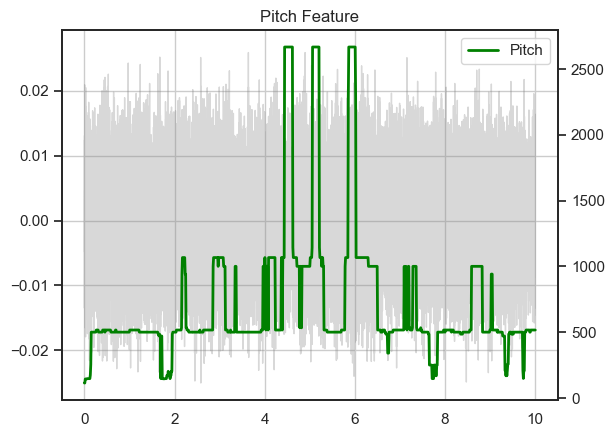

In [17]:
plot_pitch(w2, sr2, pitch2)

In [ ]:
pitch = df['filename'].apply(lambda x: df_pitch_extract(x))


In [ ]:
pitch.numpy()


## Get mean and sd of fcc

In [18]:
f = len(mfcc)
t = 8 # 8 ?
mel_n =13
#save in vectors
stddev_mfcc = []
stddev_lfcc = []
sd1 = []
sd2 = []

mean_mfcc = []
mean_lfcc = []
mean1 = []
mean2 = []
for k in range(f):
    for j in range(t):
        # Get the standard deviation
        sd1.append(np.std(mfcc[k][j], axis=0))
        sd2.append(np.std(lfcc[k][j], axis=0))

        # Get the mean
        mean1.append(np.mean(mfcc[k][j], axis=0))
        mean2.append(np.mean(lfcc[k][j], axis=0))

    mean_mfcc.append(np.mean(mean1, axis=0))
    mean_lfcc.append(np.mean(mean2, axis=0))

    stddev_mfcc.append(np.mean(sd1, axis=0))
    stddev_lfcc.append(np.mean(sd2, axis=0))

In [19]:
mfccs_features = np.hstack((stddev_mfcc, mean_mfcc))
lfcc_features = np.hstack((stddev_lfcc, mean_lfcc))

In [22]:
import numpy as np
np.save('mfcc.npy', mfccs_features )
np.save('lfcc.npy', lfcc_features )

In [ ]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sb
sb.set(style="white", palette="muted")

fig, ax = plt.subplots(nrows=len(neighbours),
                       ncols=len(distances),
                       figsize=(30, 30))

for i, row in enumerate(ax):
    for j, col in enumerate(row):
        current_plot = i * len(iterations) + j
        col.scatter(umap_embeddings_mfccs[current_plot].T[0],
                    umap_embeddings_mfccs[current_plot].T[1],
                    s=1)
plt.show()

In [ ]:
import pandas as pd
df = pd.DataFrame(mfcc_features)

In [ ]:
from sklearn.cluster import KMeans
import plotly.express as px
from sklearn.decomposition import PCA
#PCA for reducing dimensions to 3
pca = PCA(n_components=3)
pca_X = pca.fit_transform(X)


colors = np.array([x for x in 'bgrcmykbgr'])
#running k-means on resuts of pca
km_pca = KMeans(n_clusters=4).fit(pca_X)
fig = px.scatter_3d(x=pca_X[:,0], y=pca_X[:,1], z=pca_X[:,2],color=colors[km_pca.labels_])
fig.show()

In [ ]:
df_f = pd.DataFrame(